# EDA

In [539]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [540]:
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:20,.2f}'.format

Подгружаем наши датасеты

In [541]:
df_train = pd.read_csv('course_project_train.csv')

In [542]:
df_test = pd.read_csv('course_project_test.csv')

In [543]:
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]

Смотрим информацию по ним

In [544]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Как видим у нас присутствуют категориальные признаки, а также пропуски данных. Преобразуем данные

In [545]:
# Данная функция предназначена для преобразования категориальных признаков
def replace_categorical(data):
    for column in data.select_dtypes(include=['object']).columns:# Выбираем те признаки, где у нас тип данных 'object'
        count = 0 # Инициализируем счетчик
        for value in data[column].unique(): # Выбираем уникальные значения в признаке
            data[column].replace({value:count}, inplace=True) # Преобразуем данные, заменяя категорию на значение
            count += 1

In [546]:
# Данная функция предназначена для преобразования пропущенных значений
def fillna(data):
    for column in data.columns[data.isnull().any()]: # Выбираем те колонки, где есть пропущенные данные
        data[column].fillna(data[column].mean().astype(int), inplace=True) # Вставляем заместо пропущенных значений среднее и преобразуем в тип int

In [547]:
replace_categorical(X_train)
fillna(X_train)

После преобразований смотрим информацию по df

In [548]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   int64  
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int64  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   int64  
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Отрисуем боксплоты

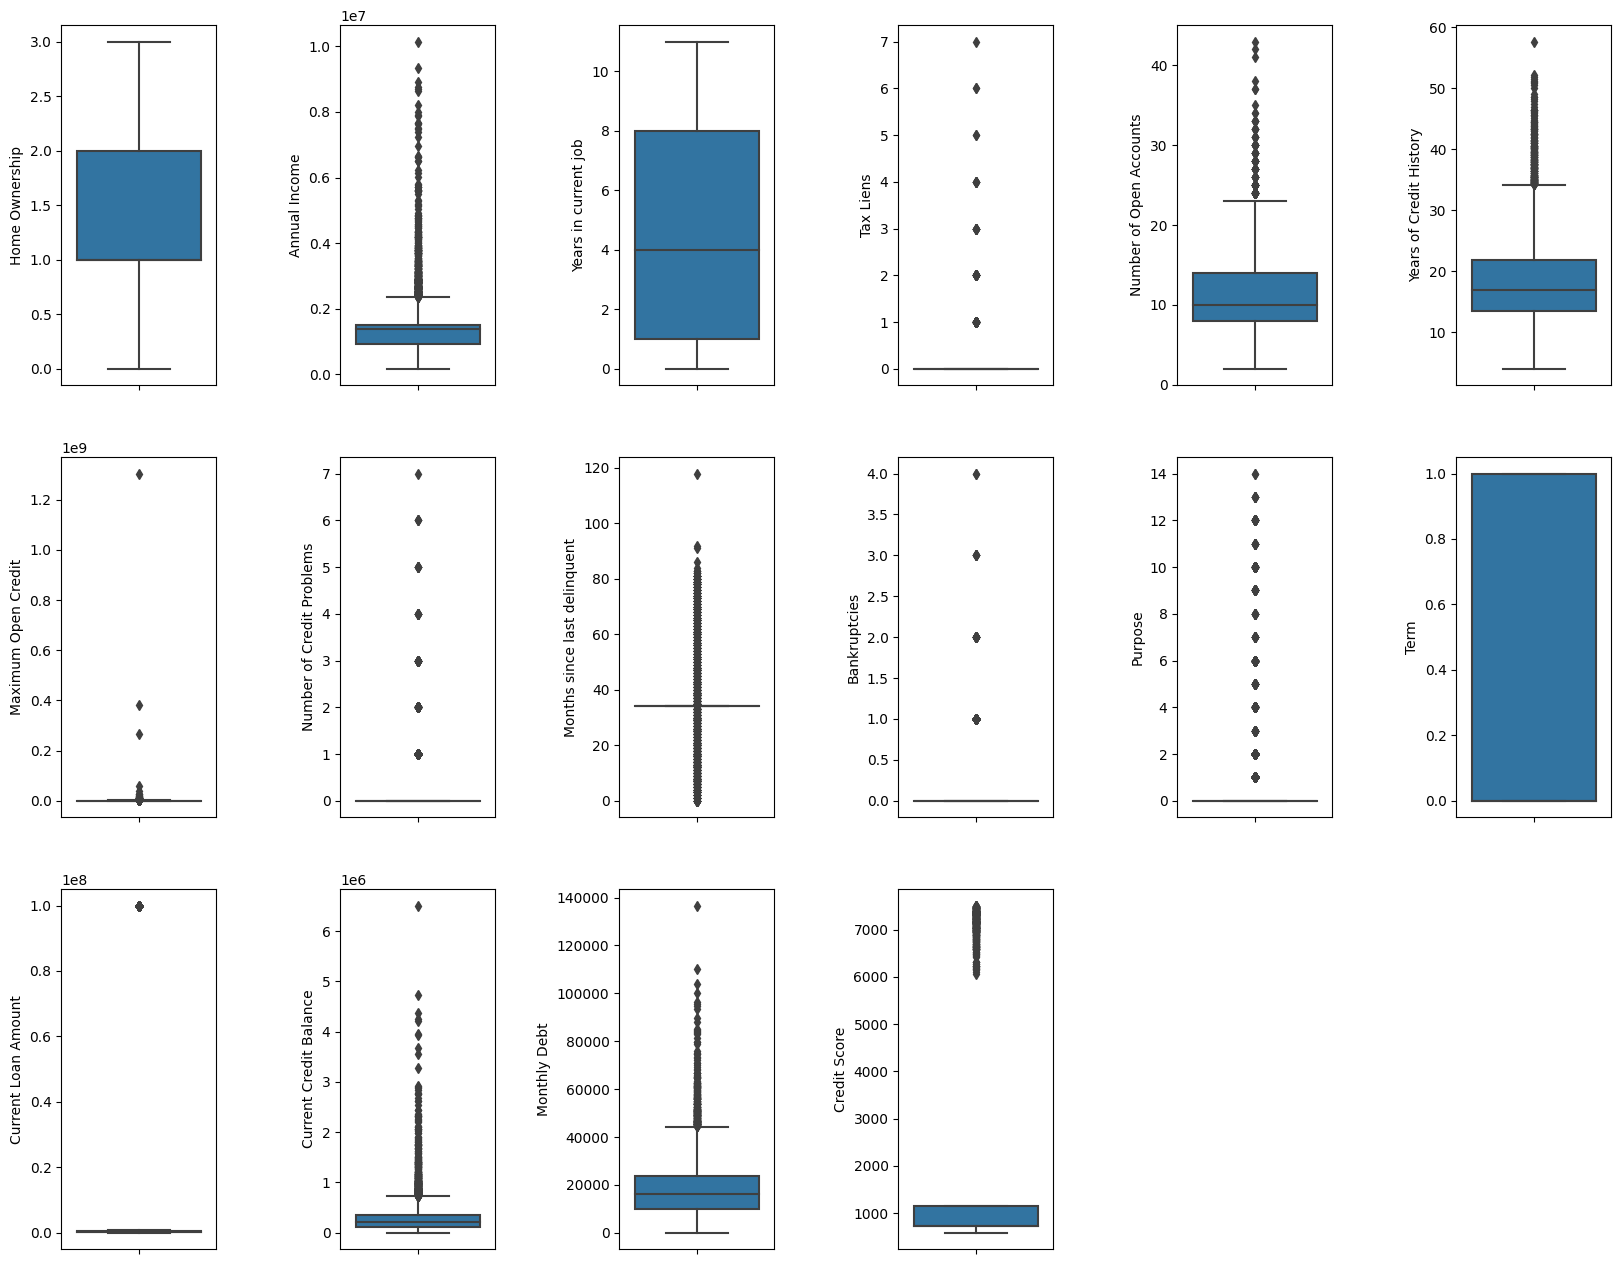

In [549]:
fig = plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace = 0.2,wspace=0.8,bottom=0.2)
for index, column in enumerate(X_train.columns):
    sns.boxplot(y=X_train[column], ax=fig.add_subplot(3,6,index+1))

Посмотрим на матрицу корреляций

<Axes: >

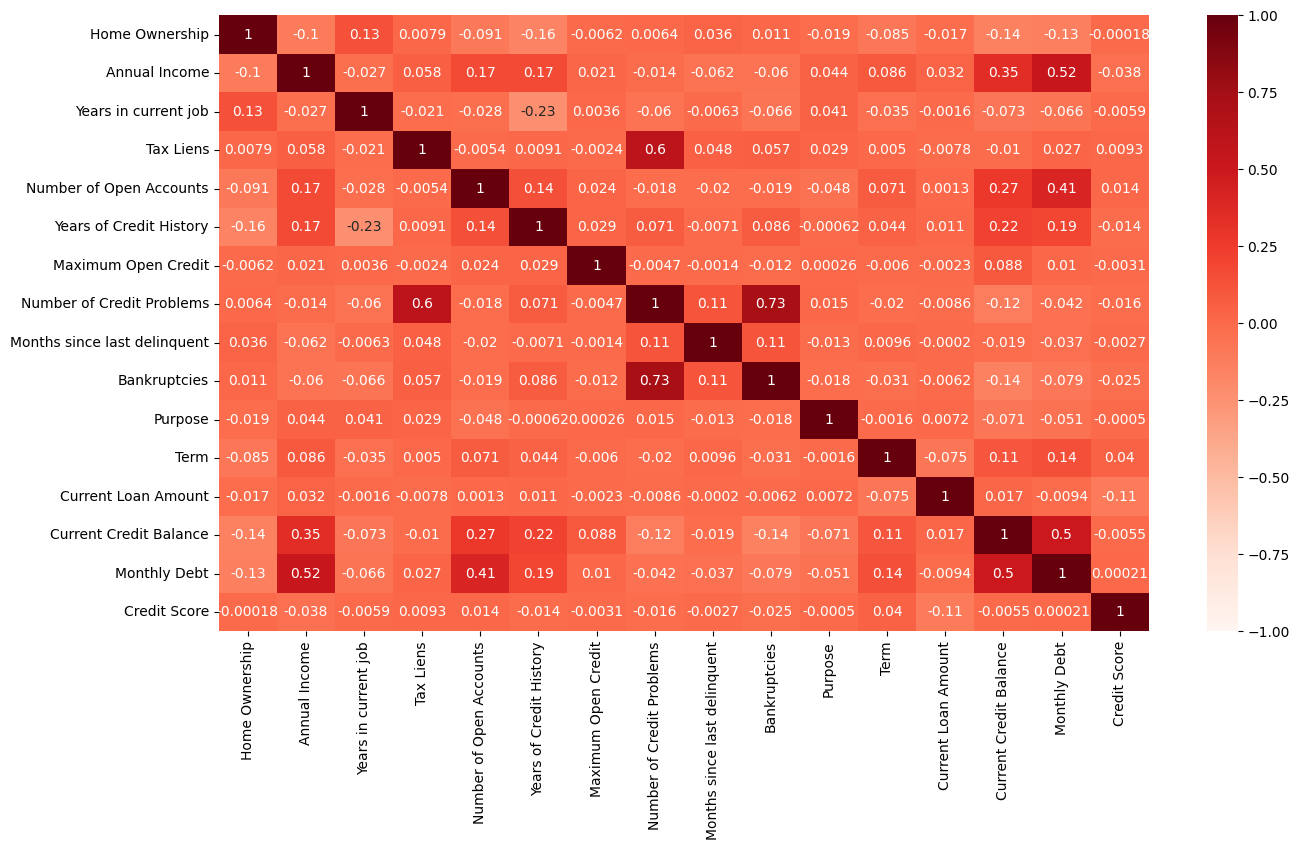

In [550]:
plt.figure(figsize=(15,8))
sns.heatmap(X_train.corr(),vmin=-1, vmax=1, cmap='Reds', annot=True)

# Построение моделей

Импорт библиотек

In [551]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
import lightgbm as lgb
import shap
from tqdm import tqdm
shap.initjs()

Разделение датасета на обучение и тест

In [552]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, random_state=13, test_size=0.2)

<b>XGBoost</b>

In [553]:
xgboost_model = xgb.XGBClassifier(random_state=13,
                                  max_depth=5,
                                  n_estimators=300,
                                  n_jobs=-1,
                                  gamma=0,
                                  scale_pos_weight=2.5,
                                  learning_rate=0.01)
xgboost_model.fit(X_train,y_train)
predict_xgb = xgboost_model.predict(X_test)

In [554]:
print(classification_report(y_pred=predict_xgb, y_true=y_test))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1077
           1       0.51      0.62      0.56       423

    accuracy                           0.72      1500
   macro avg       0.67      0.69      0.68      1500
weighted avg       0.74      0.72      0.73      1500



<b>LightGBM</b>

In [555]:
lgboost_model = lgb.LGBMClassifier(random_state=13,
                                   max_depth=5,
                                   learning_rate=0.01,
                                   n_estimators=300,
                                   objective='binary',
                                   class_weight='balanced',
                                   n_jobs=-1)
lgboost_model.fit(X_train,y_train)
predict_lgbm = lgboost_model.predict(X_test)

In [556]:
print(classification_report(y_pred=predict_lgbm, y_true=y_test))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1077
           1       0.51      0.64      0.57       423

    accuracy                           0.72      1500
   macro avg       0.68      0.70      0.68      1500
weighted avg       0.75      0.72      0.73      1500



<b>Catboost</b>

In [557]:
Catboost = CatBoostClassifier(random_state=13,
                              n_estimators=600,
                              max_depth=5,
                              l2_leaf_reg=0.3,
                              class_weights=[1,2.5],
                              custom_loss='F1',
                              loss_function='Logloss')

In [558]:
Catboost.fit(X_train, y_train,
#              cat_features=X_train.iloc[:,[0,2,10,11]].columns.to_list(),
             eval_set=(X_test, y_test),
             verbose=False,
             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [559]:
predict_catboost = Catboost.predict(X_test)

In [560]:
print(classification_report(y_pred=predict_catboost, y_true=y_test))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1077
           1       0.51      0.62      0.56       423

    accuracy                           0.73      1500
   macro avg       0.68      0.69      0.68      1500
weighted avg       0.75      0.73      0.73      1500



Как видим модели примерно получаются одинаковые. Поэтому выберем catboost 

# Визуализация влияния признаков

Далее визуализируем влияние признаков на выходные данные модели Catboost

In [561]:
explainer = shap.TreeExplainer(Catboost)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


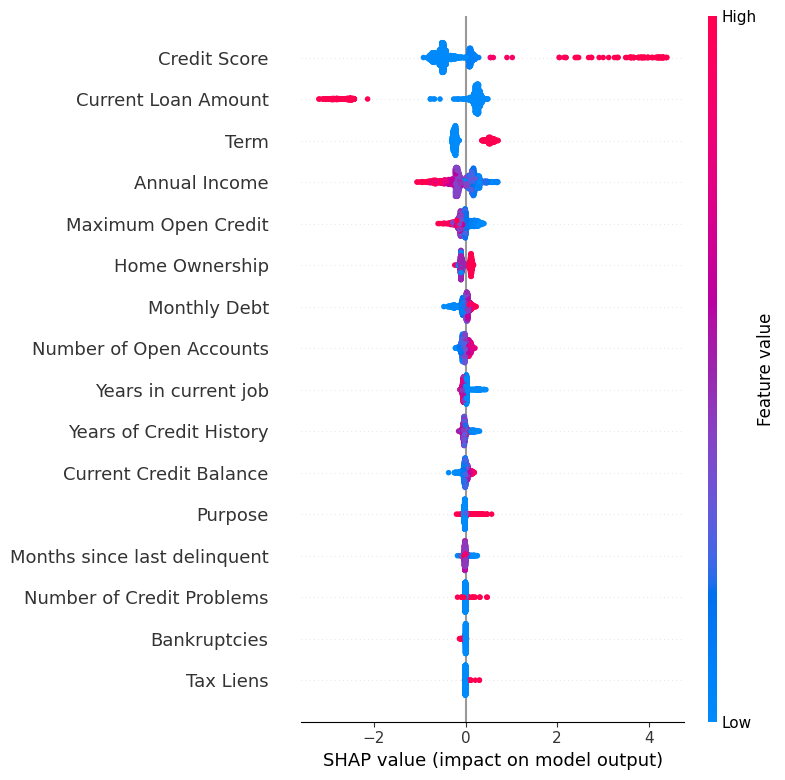

In [562]:
shap.summary_plot(shap_values_test, X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


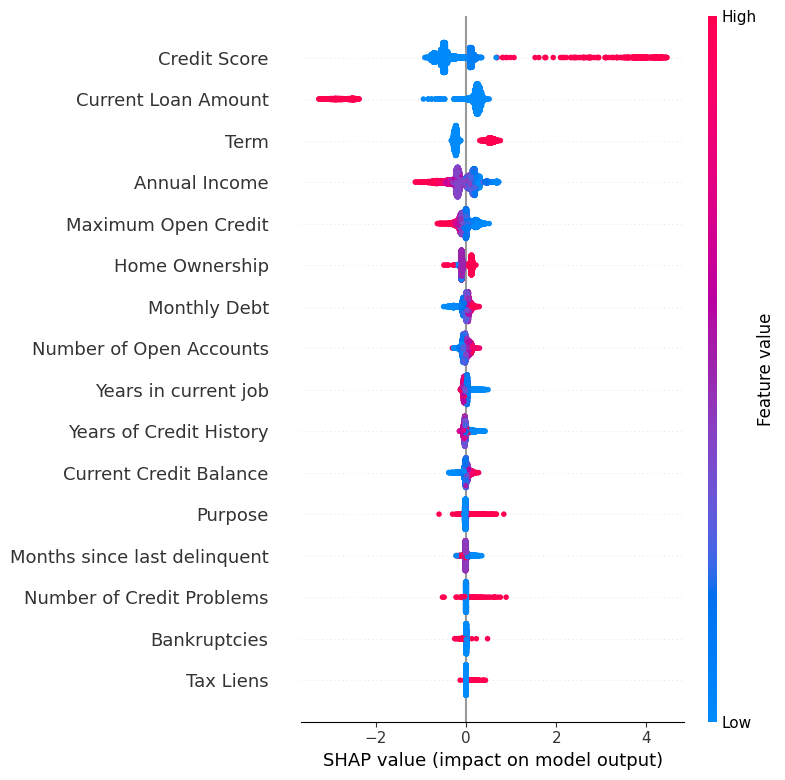

In [563]:
shap.summary_plot(shap_values_train, X_train)

Как видим признак Credit Score имеет наибольшее влияние на выходные данные

# Предсказание на тестовых данных

In [564]:
replace_categorical(df_test)
fillna(df_test)

In [565]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   int64  
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   float64
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   int64  
 11  Term                          2500 non-null   int64  
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [566]:
predict_catboost_test_data = Catboost.predict(df_test)

In [567]:
predict_catboost_test_data

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

Сохраним предсказания в файл

In [568]:
import json

In [569]:
with open ('label_lest.txt', 'w+', encoding='utf-8') as f:
    json.dump(predict_catboost_test_data.tolist(), f)